# ライブラリ読み込み

In [5]:
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold

import lightgbm as lgbm

plt.style.use("ggplot")
%matplotlib inline

# 関数読み込み

In [6]:
def rmsle(ans, pred):
    return np.sqrt(np.square(np.log1p(ans) - np.log1p(pred)).mean())

def rmse(ans, pred):
    return np.sqrt(np.square(ans - pred).mean())

In [7]:
def train_test_cat_plot(merged_data, cat_cols, n_col=2):
    n_col = 2
    n_row = len(cat_cols) // n_col + 1

    fig, axes = plt.subplots(n_row,n_col, figsize=(n_col*6, n_row*4))

    for cat_col, ax in zip(cat_cols, axes.flatten()):

        tmp = pd.pivot_table(merged_data, index=cat_col,
                                           columns="train", values='age', aggfunc="count")

        left = np.arange(len(tmp))
        train_ = tmp[0].values / tmp[0].values.sum()
        test_ = tmp[1].values / tmp[1].values.sum()
        
        ax.bar(left, train_ , width=0.4, label="train")
        ax.bar(left+0.5, test_, width=0.4, label="test")
        
        ax.set_ylim(0, max(train_.max(), test_.max())*1.1)
        ax.legend()
        ax.set_xticks(left+0.25) 
        ax.set_xticklabels(tmp.index.values)
        ax.set_title(cat_col)
    plt.show()
    return

In [8]:
def KFold_lgbm_ensemble(train_data, params, num_round=1000, K=5):
    kf = KFold(n_splits=K, random_state=2019, shuffle=True)
    split = kf.split(train_data)
    models = []
    rmsles = []
    for train_idx, val_idx in split:
        train_x = train_data.drop("charges", axis=1).values
        train_y = train_data["charges"].map(lambda y: np.log1p(y)).values
        train_x, valid_x = train_x[train_idx], train_x[val_idx]
        train_y, valid_y = train_y[train_idx], train_y[val_idx]

        # 学習
        d_train = lgbm.Dataset(train_x, label=train_y)
        d_valid = lgbm.Dataset(valid_x, label=valid_y)
        
        model = lgbm.train(params = lgbm_params,
                                           train_set =d_train,
                                           valid_sets = d_valid,
                                           num_boost_round = num_round,
                                           early_stopping_rounds = 20,
                                           verbose_eval=50)

        models.append(model)

        valid_pred = model.predict(valid_x)
        rmsles.append(rmse(valid_y, valid_pred))
        
    return models, rmsles

# データ読み込み

In [9]:
DATA_PATH = "data/"
train_data = pd.read_csv(DATA_PATH+"sample_train.csv")
test_data = pd.read_csv(DATA_PATH+"sample_test.csv")
answer_data = pd.read_csv(DATA_PATH+"sample_answer.csv")

In [10]:
train_data.head()

,id,charges,region,smoker,children,bmi,sex,age
0,0,7742.10980,southeast,no,1,26.620,male,46
1,1,8413.46305,northwest,no,2,30.495,male,45
2,2,4058.71245,northwest,no,2,33.155,male,27
3,3,11353.22760,northwest,no,0,31.540,male,57
4,4,5478.03680,southeast,no,1,29.920,female,36


In [11]:
test_data.head()

,id,region,smoker,children,bmi,sex,age
0,0,northwest,no,1,28.310,female,41
1,1,southwest,no,1,22.300,male,21
2,2,southwest,no,5,42.400,male,33
3,3,northwest,no,0,34.485,female,25
4,4,northeast,no,0,31.065,female,31


# データの確認

In [12]:
# 値のチェック
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 8 columns):
id          1070 non-null int64
charges     1070 non-null float64
region      1070 non-null object
smoker      1070 non-null object
children    1070 non-null int64
bmi         1070 non-null float64
sex         1070 non-null object
age         1070 non-null int64
dtypes: float64(2), int64(3), object(3)
memory usage: 67.0+ KB


In [ ]:
# null　チェック
train_data.isnull().sum()

In [ ]:
# 特殊なカテゴリーがあるかチェック
cat_cols = ["region", "smoker", "sex"]
for cat_col in cat_cols:
    print(train_data[cat_col].value_counts())

In [ ]:
# 各種統計量
train_data.describe()

In [ ]:
sns.pairplot(train_data,
                     vars=["charges", "region", "smoker", "children", "bmi", "sex", "age"])
plt.savefig('data/EDA/pairplot.png')
plt.close()

In [ ]:
for col in cat_cols:
    sns.pairplot(train_data, hue = col,
                         vars=["charges", "children", "bmi", "age"])
    plt.savefig(f'data/EDA/{col}_pairplot.png')
    plt.close()

In [ ]:
# train, testの分布を確認
train_data["train"] = 1
test_data["train"] = 0
merged_data = pd.concat([train_data, test_data], sort=False)

sns.pairplot(merged_data, hue="train",
                     vars=["children", "bmi", "age"])
plt.savefig(f'data/EDA/train_test_pairplot.png')
plt.close()

In [ ]:
train_test_cat_plot(merged_data,  cat_cols)

# ベースライン
KFold Ensemble

In [ ]:
train_data["children"] = train_data["children"].map(lambda x : str(x))
test_data["children"] = test_data["children"].map(lambda x : str(x))

train_data = train_data.drop("id", axis=1)
test_data = test_data.drop("id", axis=1)
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)

In [ ]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    "n_estimators": 1000,
    'num_leaves': 20,
    'max_depth': 6, 
    'learning_rate': 0.01,
    'verbose': -1, 
    "num_threads": 10}

## シングルモデル

In [ ]:
kf = KFold(n_splits=4, random_state=2019, shuffle=True)
split = kf.split(train_data)
train_idx, val_idx = split.__next__()

In [ ]:
train_x = train_data.drop("charges", axis=1).values
train_y = train_data["charges"].map(lambda y: np.log1p(y)).values
train_x, valid_x = train_x[train_idx], train_x[val_idx]
train_y, valid_y = train_y[train_idx], train_y[val_idx]

# 学習
d_train = lgbm.Dataset(train_x, label=train_y)
d_valid = lgbm.Dataset(valid_x, label=valid_y)
model = lgbm.train(params = lgbm_params,
                                   train_set =d_train,
                                   valid_sets = d_valid,
                                   num_boost_round = 1000,
                                   early_stopping_rounds = 20,
                                   verbose_eval=50)

### Private Leaderboard
0.4154697625778434

In [ ]:
test_pred = model.predict(test_data.values)
test_pred = np.exp(test_pred) - 1
print(rmsle(answer_data["charges"].values, test_pred))

## K-Fold Ensemble

In [ ]:
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)

In [ ]:
cv_rmsles = []
for i in range(9):
    K =i+2
    models, rmsles = KFold_lgbm_ensemble(train_data, lgbm_params, K=K)
    cv_rmsles.append(np.mean(rmsles))

In [ ]:
plt.plot(cv_rmsles)
plt.xticks(np.arange(10), np.arange(10)+2);

### Private Leaderboard
0.41444564295755526

In [ ]:
K = 8
models, rmsles = KFold_lgbm_ensemble(train_data, lgbm_params, K=K)

In [ ]:
test_pred = np.zeros(test_data.values.shape[0])
for model in models:
    test_pred_ = model.predict(test_data.values)
    test_pred_ = np.exp(test_pred_) - 1
    test_pred += test_pred_
test_pred = test_pred / K

print(rmsle(answer_data["charges"].values, test_pred))

# lgbm with Denoising AutoEncoder

In [13]:
from sklearn.preprocessing import QuantileTransformer

In [14]:
from get_dae_feature import preprocess, train_dae, get_representation

In [15]:
# 読み込み
train_data = pd.read_csv(DATA_PATH+"sample_train.csv")
test_data = pd.read_csv(DATA_PATH+"sample_test.csv")
train_data["train"] = 1
test_data["train"] = 0
train_y = train_data["charges"].values

num_cols = ["bmi", "age"]
cat_cols = ["children", "region", "smoker", "sex"]

# dae用にmerge
merged_data = pd.concat([train_data, test_data], sort=False)
merged_data = merged_data.drop(["id", "charges"], axis=1)
merged_data["children"] = merged_data["children"].map(lambda x: str(x))

In [21]:
# rankgauss & one hot & swap noise
one_hot_noised_df,one_hot_df = preprocess(merged_data, num_cols, cat_cols)

# train, test data
train_x = one_hot_df.query("train == 1").drop("train", axis=1)
test_x = one_hot_df.query("train == 0").drop("train", axis=1)

In [22]:
train_dae(one_hot_noised_df, "cuda:9", "models/dae.model", cycle=300)

0.5704843429001895
0.23243783685294064
0.1498781903223558
0.10720068284056404
0.08029152656143362
0.0633940774608742
0.05081037025560032
0.04158374802632765
0.03495896980166435
0.029727314683524044


In [23]:
train_x = get_representation(train_x.values, "models/dae.model")
test_x =  get_representation(test_x.values, "models/dae.model")

train_data_ = pd.DataFrame(train_x)
train_data_["charges"] = train_y

## シングルモデル

In [24]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    "n_estimators": 1000,
    'num_leaves': 20,
    'max_depth': 6, 
    'learning_rate': 0.01,
    'verbose': -1, 
    "num_threads": 10}

In [25]:
kf = KFold(n_splits=4, random_state=2019, shuffle=True)
split = kf.split(train_data_)
train_idx, val_idx = split.__next__()

train_x = train_data_.drop("charges", axis=1).values
train_y = train_data_["charges"].map(lambda y: np.log1p(y)).values
train_x, valid_x = train_x[train_idx], train_x[val_idx]
train_y, valid_y = train_y[train_idx], train_y[val_idx]

# 学習
d_train = lgbm.Dataset(train_x, label=train_y)
d_valid = lgbm.Dataset(valid_x, label=valid_y)
model = lgbm.train(params = lgbm_params,
                                   train_set =d_train,
                                   valid_sets = d_valid,
                                   num_boost_round = 1000,
                                   early_stopping_rounds = 20,
                                   verbose_eval=50)

Training until validation scores don't improve for 20 rounds.
[50]	valid_0's rmse: 0.745558
[100]	valid_0's rmse: 0.620563


/home/k-syo/.local/share/virtualenvs/lgbm-dae-optuna-16RmQPvN/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[150]	valid_0's rmse: 0.554539
[200]	valid_0's rmse: 0.511548
[250]	valid_0's rmse: 0.486817
[300]	valid_0's rmse: 0.472185
[350]	valid_0's rmse: 0.462715
[400]	valid_0's rmse: 0.456808
[450]	valid_0's rmse: 0.451936
[500]	valid_0's rmse: 0.447999
[550]	valid_0's rmse: 0.445098
[600]	valid_0's rmse: 0.442985
[650]	valid_0's rmse: 0.44071
[700]	valid_0's rmse: 0.439027
[750]	valid_0's rmse: 0.43824
[800]	valid_0's rmse: 0.437468
[850]	valid_0's rmse: 0.437
[900]	valid_0's rmse: 0.436514
Early stopping, best iteration is:
[927]	valid_0's rmse: 0.436179


### Private Leaderbord
0.4918090458936207

In [27]:
test_pred = model.predict(test_x)
test_pred = np.exp(test_pred) - 1
print(rmsle(answer_data["charges"].values, test_pred))

0.4918090458936207


## K-Fold Ensembel

In [28]:
cv_rmsles = []
for i in range(9):
    K =i+2
    models, rmsles = KFold_lgbm_ensemble(train_data_, lgbm_params, K=K)
    cv_rmsles.append(np.mean(rmsles))

Training until validation scores don't improve for 20 rounds.
[50]	valid_0's rmse: 0.724139
[100]	valid_0's rmse: 0.610417
[150]	valid_0's rmse: 0.547908
[200]	valid_0's rmse: 0.513189
[250]	valid_0's rmse: 0.493318
[300]	valid_0's rmse: 0.480814
[350]	valid_0's rmse: 0.47522
[400]	valid_0's rmse: 0.471322
[450]	valid_0's rmse: 0.468967
[500]	valid_0's rmse: 0.467241
[550]	valid_0's rmse: 0.465996
[600]	valid_0's rmse: 0.4655
[650]	valid_0's rmse: 0.464995
[700]	valid_0's rmse: 0.464443
Early stopping, best iteration is:
[728]	valid_0's rmse: 0.46436
Training until validation scores don't improve for 20 rounds.
[50]	valid_0's rmse: 0.713215
[100]	valid_0's rmse: 0.599316
[150]	valid_0's rmse: 0.547687
[200]	valid_0's rmse: 0.520789
[250]	valid_0's rmse: 0.504825
[300]	valid_0's rmse: 0.495849
[350]	valid_0's rmse: 0.488817
[400]	valid_0's rmse: 0.484455
[450]	valid_0's rmse: 0.480821
[500]	valid_0's rmse: 0.478303
[550]	valid_0's rmse: 0.477033
[600]	valid_0's rmse: 0.476012
[650]	vali

[550]	valid_0's rmse: 0.46154
[600]	valid_0's rmse: 0.459808
[650]	valid_0's rmse: 0.458275
[700]	valid_0's rmse: 0.457428
[750]	valid_0's rmse: 0.45687
[800]	valid_0's rmse: 0.45661
[850]	valid_0's rmse: 0.456138
[900]	valid_0's rmse: 0.455514
[950]	valid_0's rmse: 0.455456
Early stopping, best iteration is:
[945]	valid_0's rmse: 0.455347
Training until validation scores don't improve for 20 rounds.
[50]	valid_0's rmse: 0.758753
[100]	valid_0's rmse: 0.642397
[150]	valid_0's rmse: 0.572611
[200]	valid_0's rmse: 0.534296
[250]	valid_0's rmse: 0.511136
[300]	valid_0's rmse: 0.497611
[350]	valid_0's rmse: 0.486723
[400]	valid_0's rmse: 0.47856
[450]	valid_0's rmse: 0.472452
[500]	valid_0's rmse: 0.467627
[550]	valid_0's rmse: 0.464397
[600]	valid_0's rmse: 0.462159
[650]	valid_0's rmse: 0.460705
Early stopping, best iteration is:
[662]	valid_0's rmse: 0.460565
Training until validation scores don't improve for 20 rounds.
[50]	valid_0's rmse: 0.721134
[100]	valid_0's rmse: 0.605975
[150]	

[100]	valid_0's rmse: 0.602204
[150]	valid_0's rmse: 0.535476
[200]	valid_0's rmse: 0.492818
[250]	valid_0's rmse: 0.472194
[300]	valid_0's rmse: 0.458688
[350]	valid_0's rmse: 0.451634
[400]	valid_0's rmse: 0.447587
[450]	valid_0's rmse: 0.443856
[500]	valid_0's rmse: 0.441005
[550]	valid_0's rmse: 0.437548
[600]	valid_0's rmse: 0.433614
[650]	valid_0's rmse: 0.430632
[700]	valid_0's rmse: 0.428788
[750]	valid_0's rmse: 0.427398
[800]	valid_0's rmse: 0.425764
[850]	valid_0's rmse: 0.42493
[900]	valid_0's rmse: 0.424623
Early stopping, best iteration is:
[896]	valid_0's rmse: 0.424481
Training until validation scores don't improve for 20 rounds.
[50]	valid_0's rmse: 0.686451
[100]	valid_0's rmse: 0.576148
[150]	valid_0's rmse: 0.518632
[200]	valid_0's rmse: 0.485306
[250]	valid_0's rmse: 0.468774
[300]	valid_0's rmse: 0.456458
[350]	valid_0's rmse: 0.449571
[400]	valid_0's rmse: 0.444915
[450]	valid_0's rmse: 0.441178
[500]	valid_0's rmse: 0.438664
[550]	valid_0's rmse: 0.436366
[600]	

[300]	valid_0's rmse: 0.515652
[350]	valid_0's rmse: 0.514909
Early stopping, best iteration is:
[332]	valid_0's rmse: 0.514469
Training until validation scores don't improve for 20 rounds.
[50]	valid_0's rmse: 0.743489
[100]	valid_0's rmse: 0.619855
[150]	valid_0's rmse: 0.555696
[200]	valid_0's rmse: 0.515135
[250]	valid_0's rmse: 0.493917
[300]	valid_0's rmse: 0.477123
[350]	valid_0's rmse: 0.466193
[400]	valid_0's rmse: 0.460187
[450]	valid_0's rmse: 0.457201
[500]	valid_0's rmse: 0.454784
[550]	valid_0's rmse: 0.45306
[600]	valid_0's rmse: 0.450433
[650]	valid_0's rmse: 0.448188
[700]	valid_0's rmse: 0.44651
[750]	valid_0's rmse: 0.444358
[800]	valid_0's rmse: 0.443195
[850]	valid_0's rmse: 0.441719
[900]	valid_0's rmse: 0.441217
[950]	valid_0's rmse: 0.440622
Early stopping, best iteration is:
[964]	valid_0's rmse: 0.440325
Training until validation scores don't improve for 20 rounds.
[50]	valid_0's rmse: 0.79484
[100]	valid_0's rmse: 0.684147
[150]	valid_0's rmse: 0.614272
[200]

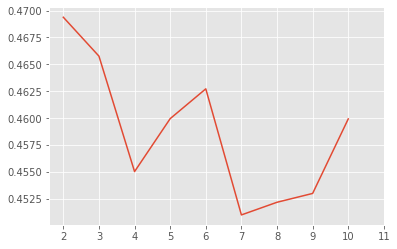

In [29]:
plt.plot(cv_rmsles)
plt.xticks(np.arange(10), np.arange(10)+2);

### Private Leaderbord
0.47777799479688304

In [30]:
K = 7
models, rmsles = KFold_lgbm_ensemble(train_data_, lgbm_params, K=K)

Training until validation scores don't improve for 20 rounds.
[50]	valid_0's rmse: 0.763668
[100]	valid_0's rmse: 0.654
[150]	valid_0's rmse: 0.579266
[200]	valid_0's rmse: 0.540122
[250]	valid_0's rmse: 0.518831
[300]	valid_0's rmse: 0.505463
[350]	valid_0's rmse: 0.495335
[400]	valid_0's rmse: 0.489123
[450]	valid_0's rmse: 0.483031
[500]	valid_0's rmse: 0.477761
[550]	valid_0's rmse: 0.474143
[600]	valid_0's rmse: 0.471582
[650]	valid_0's rmse: 0.470021
[700]	valid_0's rmse: 0.468804
[750]	valid_0's rmse: 0.467844
[800]	valid_0's rmse: 0.466708
[850]	valid_0's rmse: 0.466161
[900]	valid_0's rmse: 0.465404
[950]	valid_0's rmse: 0.46474
[1000]	valid_0's rmse: 0.463809
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 0.463804
Training until validation scores don't improve for 20 rounds.
[50]	valid_0's rmse: 0.717674
[100]	valid_0's rmse: 0.582931
[150]	valid_0's rmse: 0.512208
[200]	valid_0's rmse: 0.474377
[250]	valid_0's rmse: 0.451456
[300]	valid_0's rmse: 0.438

In [31]:
test_pred = np.zeros(test_x.shape[0])
for model in models:
    test_pred_ = model.predict(test_x)
    test_pred_ = np.exp(test_pred_) - 1
    test_pred += test_pred_
test_pred = test_pred / K

print(rmsle(answer_data["charges"].values, test_pred))

0.47777799479688304
